In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm
import chardet
import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn import linear_model

from sklearn.svm import SVR
from sklearn.svm import LinearSVC

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, f1_score

from sklearn.preprocessing import StandardScaler

In [2]:
# Attempting to model DOM (Days on markets) of each property
df = pd.read_csv('../data/denver_mean_dom_discretize.csv')

df["list_date"] = pd.to_datetime(df["list_date"])
df["sale_date"] = pd.to_datetime(df["sale_date"])

mapping = {k: v for v, k in enumerate(df.property_type.unique())}
mapping

{'SINGLE': 0,
 'CONDO': 1,
 'MULTI_FAMILY': 2,
 'LAND': 3,
 'OTHER': 4,
 'TOWNHOUSE': 5}

In [3]:
scaler = StandardScaler()

In [4]:
df['dom'] = (df['sale_date'] - df['list_date']).dt.days.astype('int16')
df = df[(df['sqft'] < 6000) & (df['sale_price_per_sqft'] < 500)].copy()
df['property_type_code'] = df['property_type'].map(mapping)

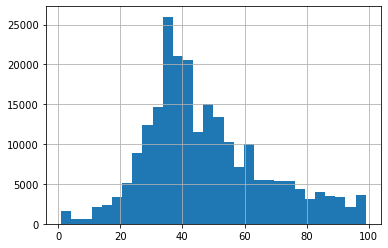

In [5]:
df['dom'].hist(bins=30)

In [6]:
df.describe()

,property_id,zipcode,fips,sqft,sale_price_per_sqft,farm_score,median_rental_price,pop_density,first_time_homebuyer_score,retirement_friendly_score,young_single_professional_score,college_student_friendly_score,violent_crime_rate,walk,public_transportation,carpool,dom,mean_dom,dom_bucket,property_type_code
count,2.324980e+05,232498.00000,232498.000000,232498.000000,232498.000000,232498.000000,232498.000000,232498.000000,232498.000000,232498.000000,232498.000000,232498.000000,232498.000000,232498.000000,232498.000000,232498.000000,232498.000000,232498.000000,232498.000000,232498.000000
mean,2.345544e+08,80204.90221,8142.678771,1927.604547,235.278704,86.785048,2155.167381,4454.681361,64.241069,62.062904,41.975798,59.048684,4.318042,0.017281,0.035283,0.079935,47.434851,47.403507,1.133713,0.314368
std,1.787886e+08,178.40921,2030.741351,907.524772,77.197999,29.297348,581.299342,3202.533467,38.305556,23.835901,13.238119,22.919682,3.744564,0.031375,0.031316,0.039587,19.413427,2.293873,0.697080,0.552592
min,1.021800e+04,80002.00000,5069.000000,120.000000,0.624376,0.000000,935.000000,1.190135,0.383779,0.710770,3.042529,3.956666,0.000000,0.000000,0.000000,0.000000,1.000000,40.695264,0.000000,0.000000
25%,1.386529e+08,80030.00000,8005.000000,1260.000000,181.023720,100.000000,1724.000000,2136.487544,24.969933,45.952597,34.510855,41.245291,1.620370,0.003164,0.012418,0.053691,34.000000,45.826744,1.000000,0.000000
50%,1.401357e+08,80204.00000,8031.000000,1750.000000,219.026549,100.000000,2077.000000,4137.942853,100.000000,66.516814,45.040448,61.079491,3.022453,0.008577,0.027169,0.072952,43.000000,47.352444,1.000000,0.000000
75%,3.219761e+08,80241.00000,8059.000000,2384.000000,272.203667,100.000000,2485.000000,6082.974111,100.000000,81.925541,50.886820,77.841018,5.956320,0.019688,0.048770,0.098507,58.000000,49.056486,1.000000,1.000000
max,2.146689e+09,80643.00000,51153.000000,5995.000000,499.886364,100.000000,5009.000000,31336.205118,100.000000,99.975254,78.137148,99.363469,39.370079,0.457666,0.204571,0.316316,99.000000,52.942220,3.000000,5.000000


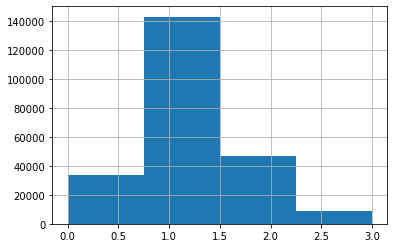

In [7]:
df['dom_bucket'].hist(bins=4)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 232498 entries, 0 to 232497
Data columns (total 28 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   property_id                      232498 non-null  int64         
 1   zipcode                          232498 non-null  int64         
 2   fips                             232498 non-null  float64       
 3   sqft                             232498 non-null  float64       
 4   property_type                    232498 non-null  object        
 5   has_central_air                  232498 non-null  bool          
 6   has_jacuzzi                      232498 non-null  bool          
 7   has_pool                         232498 non-null  bool          
 8   has_solar                        232498 non-null  bool          
 9   has_garage                       232498 non-null  bool          
 10  list_date                        232498 non-

count    232498.000000
mean       1927.604547
std         907.524772
min         120.000000
25%        1260.000000
50%        1750.000000
75%        2384.000000
max        5995.000000
Name: sqft, dtype: float64


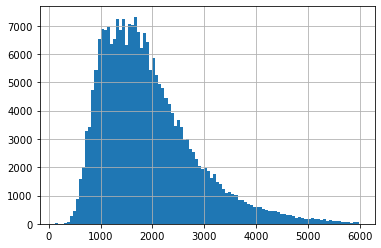

In [9]:
print(df['sqft'].describe())
df['sqft'].hist(bins=100)

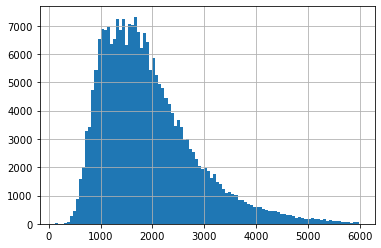

In [10]:
df['sqft'].hist(bins=100)

In [11]:
df['sale_price_per_sqft'].describe()

count    232498.000000
mean        235.278704
std          77.197999
min           0.624376
25%         181.023720
50%         219.026549
75%         272.203667
max         499.886364
Name: sale_price_per_sqft, dtype: float64

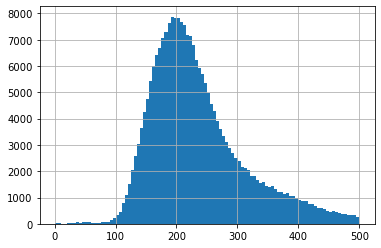

In [12]:
df['sale_price_per_sqft'].hist(bins=100)

In [13]:
df = df[(df['dom'] > 0) & (df['dom'] < 100)]

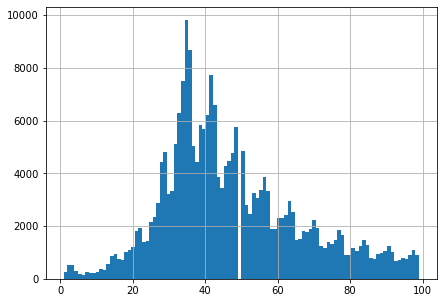

In [14]:
df['dom'].hist(bins=100, figsize=(7, 5))

In [15]:
df.describe()

,property_id,zipcode,fips,sqft,sale_price_per_sqft,farm_score,median_rental_price,pop_density,first_time_homebuyer_score,retirement_friendly_score,young_single_professional_score,college_student_friendly_score,violent_crime_rate,walk,public_transportation,carpool,dom,mean_dom,dom_bucket,property_type_code
count,2.324980e+05,232498.00000,232498.000000,232498.000000,232498.000000,232498.000000,232498.000000,232498.000000,232498.000000,232498.000000,232498.000000,232498.000000,232498.000000,232498.000000,232498.000000,232498.000000,232498.000000,232498.000000,232498.000000,232498.000000
mean,2.345544e+08,80204.90221,8142.678771,1927.604547,235.278704,86.785048,2155.167381,4454.681361,64.241069,62.062904,41.975798,59.048684,4.318042,0.017281,0.035283,0.079935,47.434851,47.403507,1.133713,0.314368
std,1.787886e+08,178.40921,2030.741351,907.524772,77.197999,29.297348,581.299342,3202.533467,38.305556,23.835901,13.238119,22.919682,3.744564,0.031375,0.031316,0.039587,19.413427,2.293873,0.697080,0.552592
min,1.021800e+04,80002.00000,5069.000000,120.000000,0.624376,0.000000,935.000000,1.190135,0.383779,0.710770,3.042529,3.956666,0.000000,0.000000,0.000000,0.000000,1.000000,40.695264,0.000000,0.000000
25%,1.386529e+08,80030.00000,8005.000000,1260.000000,181.023720,100.000000,1724.000000,2136.487544,24.969933,45.952597,34.510855,41.245291,1.620370,0.003164,0.012418,0.053691,34.000000,45.826744,1.000000,0.000000
50%,1.401357e+08,80204.00000,8031.000000,1750.000000,219.026549,100.000000,2077.000000,4137.942853,100.000000,66.516814,45.040448,61.079491,3.022453,0.008577,0.027169,0.072952,43.000000,47.352444,1.000000,0.000000
75%,3.219761e+08,80241.00000,8059.000000,2384.000000,272.203667,100.000000,2485.000000,6082.974111,100.000000,81.925541,50.886820,77.841018,5.956320,0.019688,0.048770,0.098507,58.000000,49.056486,1.000000,1.000000
max,2.146689e+09,80643.00000,51153.000000,5995.000000,499.886364,100.000000,5009.000000,31336.205118,100.000000,99.975254,78.137148,99.363469,39.370079,0.457666,0.204571,0.316316,99.000000,52.942220,3.000000,5.000000


In [16]:
def calculate_mean_dom(x):
  before = x['list_date'] - pd.Timedelta(days=90)
  
  near_dates = df[(df['list_date'] >= before) & (df['list_date'] < x['list_date'])]
  mean_dom = near_dates['dom'].mean()
  if mean_dom > 0:
    x.at['mean_dom'] = mean_dom
  return x

In [17]:
# df['mean_dom'] = df['dom'].mean()

In [18]:
# df = df.apply(calculate_mean_dom, axis=1)

In [19]:
# df['mean_dom'].hist(bins=20)

In [20]:
def discretize_dom(x):
  if x['dom'] < 90:
    x.at['dom_bucket'] = x['dom'] // 30
  else:
    x.at['dom_bucket'] = 3
  return x

In [21]:
# df['dom_bucket'] = 0
# df = df.apply(discretize_dom, axis=1)

In [22]:
# df.to_csv('../data/denver_mean_dom_discretize.csv', index=False)

In [23]:
# df['dom_bucket'].hist(bins=4)

## Regression Model

In [24]:
y = df['dom'].copy()

X = df.drop(columns=['property_id', 'list_date', 'sale_date', 'dom', 
                     'farm_score', 'fips', 
                     'first_time_homebuyer_score', 'dom_bucket', 'property_type'])

columns_to_scale = ['zipcode', 'sqft', 'sale_price_per_sqft', 'median_rental_price', 
                    'pop_density', 'retirement_friendly_score',
                    'college_student_friendly_score', 'violent_crime_rate', 'young_single_professional_score',
                    'property_type_code'
                   ]
X[columns_to_scale] =  scaler.fit_transform(X[columns_to_scale])

X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 232498 entries, 0 to 232497
Data columns (total 19 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   zipcode                          232498 non-null  float64
 1   sqft                             232498 non-null  float64
 2   has_central_air                  232498 non-null  bool   
 3   has_jacuzzi                      232498 non-null  bool   
 4   has_pool                         232498 non-null  bool   
 5   has_solar                        232498 non-null  bool   
 6   has_garage                       232498 non-null  bool   
 7   sale_price_per_sqft              232498 non-null  float64
 8   median_rental_price              232498 non-null  float64
 9   pop_density                      232498 non-null  float64
 10  retirement_friendly_score        232498 non-null  float64
 11  young_single_professional_score  232498 non-null  float64
 12  co

In [25]:
X.describe()

,zipcode,sqft,sale_price_per_sqft,median_rental_price,pop_density,retirement_friendly_score,young_single_professional_score,college_student_friendly_score,violent_crime_rate,walk,public_transportation,carpool,mean_dom,property_type_code
count,2.324980e+05,2.324980e+05,2.324980e+05,2.324980e+05,2.324980e+05,2.324980e+05,2.324980e+05,2.324980e+05,2.324980e+05,232498.000000,232498.000000,232498.000000,232498.000000,2.324980e+05
mean,1.852548e-13,1.763210e-15,5.178463e-15,3.651967e-14,-2.412038e-14,-2.007045e-16,3.521633e-14,1.622260e-14,1.667492e-14,0.017281,0.035283,0.079935,47.403507,4.028315e-14
std,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,0.031375,0.031316,0.039587,2.293873,1.000002e+00
min,-1.137288e+00,-1.991801e+00,-3.039649e+00,-2.099039e+00,-1.390618e+00,-2.573944e+00,-2.941003e+00,-2.403704e+00,-1.153152e+00,0.000000,0.000000,0.000000,40.695264,-5.688988e-01
25%,-9.803451e-01,-7.356339e-01,-7.028045e-01,-7.417320e-01,-7.238640e-01,-6.758856e-01,-5.638988e-01,-7.767748e-01,-7.204252e-01,0.003164,0.012418,0.053691,45.826744,-5.688988e-01
50%,-5.056980e-03,-1.957026e-01,-2.105261e-01,-1.344704e-01,-9.890269e-02,1.868576e-01,2.315024e-01,8.860555e-02,-3.459928e-01,0.008577,0.027169,0.072952,47.352444,-5.688988e-01
75%,2.023319e-01,5.029025e-01,4.783161e-01,5.674070e-01,5.084400e-01,8.333093e-01,6.731350e-01,8.199230e-01,4.375093e-01,0.019688,0.048770,0.098507,49.056486,1.240758e+00
max,2.455584e+00,4.481866e+00,3.427657e+00,4.909413e+00,8.393849e+00,1.590560e+00,2.731614e+00,1.758963e+00,9.360801e+00,0.457666,0.204571,0.316316,52.942220,8.479386e+00


In [26]:
X.head()

,zipcode,sqft,has_central_air,has_jacuzzi,has_pool,has_solar,has_garage,sale_price_per_sqft,median_rental_price,pop_density,retirement_friendly_score,young_single_professional_score,college_student_friendly_score,violent_crime_rate,walk,public_transportation,carpool,mean_dom,property_type_code
0,-1.137288,-0.265122,False,False,False,False,False,-0.360241,0.395378,-0.355144,0.203699,0.120193,0.365309,-0.414889,0.015244,0.016463,0.080793,44.002865,-0.568899
1,-1.137288,0.322191,False,False,False,False,False,-0.567856,0.395378,-0.355144,0.203699,0.120193,0.365309,-0.414889,0.015244,0.016463,0.080793,50.991020,-0.568899
2,-1.137288,0.219714,False,False,False,False,False,-0.234092,0.395378,-0.355144,0.203699,0.120193,0.365309,-0.414889,0.015244,0.016463,0.080793,49.099593,-0.568899
3,-1.137288,0.219714,False,False,False,False,False,0.295751,0.395378,-0.355144,0.203699,0.120193,0.365309,-0.414889,0.015244,0.016463,0.080793,50.221719,-0.568899
4,-1.137288,-1.249120,False,False,False,False,False,0.949321,0.395378,-0.355144,0.203699,0.120193,0.365309,-0.414889,0.015244,0.016463,0.080793,45.992668,1.240758


In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [28]:
regression_models = {
  'Linear regression': LinearRegression(),
  'Ridge': Ridge(alpha=1.0),
  'Lasso': linear_model.Lasso(alpha=0.1),
  'Random Forest Regression': RandomForestRegressor(max_depth=2, random_state=0),
#   'Support Vector Regression': SVR(C=1.0, epsilon=0.2)
}

In [29]:
for md in regression_models.keys():
  res = regression_models[md].fit(X_train, y_train)
  print('Result for {}'.format(md))
  print('Train set R2: {}'.format(res.score(X_train, y_train)))
  print('Test set R2: {}'.format(res.score(X_test, y_test)))
  y_pred = res.predict(X_test)
  print('Test set MSE: {}'.format(mean_squared_error(y_test, y_pred)))
  print('')

Result for Linear regression
Train set R2: 0.04752564469602194
Test set R2: 0.0501209045833555
Test set MSE: 360.0401672710131

Result for Ridge
Train set R2: 0.04752553033714091
Test set R2: 0.050120048718724886
Test set MSE: 360.0404916761361

Result for Lasso
Train set R2: 0.04586082952296633
Test set R2: 0.04815643862790486
Test set MSE: 360.78477430006706

Result for Random Forest Regression
Train set R2: 0.03124591132505905
Test set R2: 0.031794279986013585
Test set MSE: 366.986652373568



## Classification models

In [30]:
y2 = df['dom_bucket'].copy()

X2 = df.drop(columns=['property_id', 'list_date', 'sale_date', 'dom', 
                     'farm_score', 'fips', 
                     'first_time_homebuyer_score', 'dom_bucket', 'property_type'])

columns_to_scale = ['zipcode', 'sqft', 'sale_price_per_sqft', 'median_rental_price', 
                    'pop_density', 'retirement_friendly_score',
                    'college_student_friendly_score', 'violent_crime_rate', 'young_single_professional_score',
                    'property_type_code'
                   ]
X2[columns_to_scale] =  scaler.fit_transform(X[columns_to_scale])

X2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 232498 entries, 0 to 232497
Data columns (total 19 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   zipcode                          232498 non-null  float64
 1   sqft                             232498 non-null  float64
 2   has_central_air                  232498 non-null  bool   
 3   has_jacuzzi                      232498 non-null  bool   
 4   has_pool                         232498 non-null  bool   
 5   has_solar                        232498 non-null  bool   
 6   has_garage                       232498 non-null  bool   
 7   sale_price_per_sqft              232498 non-null  float64
 8   median_rental_price              232498 non-null  float64
 9   pop_density                      232498 non-null  float64
 10  retirement_friendly_score        232498 non-null  float64
 11  young_single_professional_score  232498 non-null  float64
 12  co

In [31]:
X2.describe()

,zipcode,sqft,sale_price_per_sqft,median_rental_price,pop_density,retirement_friendly_score,young_single_professional_score,college_student_friendly_score,violent_crime_rate,walk,public_transportation,carpool,mean_dom,property_type_code
count,2.324980e+05,2.324980e+05,2.324980e+05,2.324980e+05,2.324980e+05,2.324980e+05,2.324980e+05,2.324980e+05,2.324980e+05,232498.000000,232498.000000,232498.000000,232498.000000,2.324980e+05
mean,1.808828e-13,1.763210e-15,4.625204e-15,3.651968e-14,-2.412036e-14,-1.984752e-16,3.521633e-14,1.622260e-14,1.667492e-14,0.017281,0.035283,0.079935,47.403507,4.028329e-14
std,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,0.031375,0.031316,0.039587,2.293873,1.000002e+00
min,-1.137288e+00,-1.991801e+00,-3.039649e+00,-2.099039e+00,-1.390618e+00,-2.573944e+00,-2.941003e+00,-2.403704e+00,-1.153152e+00,0.000000,0.000000,0.000000,40.695264,-5.688988e-01
25%,-9.803451e-01,-7.356339e-01,-7.028045e-01,-7.417320e-01,-7.238640e-01,-6.758856e-01,-5.638988e-01,-7.767748e-01,-7.204252e-01,0.003164,0.012418,0.053691,45.826744,-5.688988e-01
50%,-5.056980e-03,-1.957026e-01,-2.105261e-01,-1.344704e-01,-9.890269e-02,1.868576e-01,2.315024e-01,8.860555e-02,-3.459928e-01,0.008577,0.027169,0.072952,47.352444,-5.688988e-01
75%,2.023319e-01,5.029025e-01,4.783161e-01,5.674070e-01,5.084400e-01,8.333093e-01,6.731350e-01,8.199230e-01,4.375093e-01,0.019688,0.048770,0.098507,49.056486,1.240758e+00
max,2.455584e+00,4.481866e+00,3.427657e+00,4.909413e+00,8.393849e+00,1.590560e+00,2.731614e+00,1.758963e+00,9.360801e+00,0.457666,0.204571,0.316316,52.942220,8.479386e+00


In [32]:
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.33)

In [33]:
def print_results(model):
  print('Train set accuracy: {}'.format(model.score(X_train, y_train)))
  print('Test set accuracy: {}'.format(model.score(X_test, y_test)))

### Logistic Regression

In [34]:
logit_reg = LogisticRegression()
logit_reg.fit(X_train, y_train)

print_results(logit_reg)

/Users/namluu/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train set accuracy: 0.6140987205741688
Test set accuracy: 0.6140632127728902


### Extra Trees Classifier

In [36]:
etc = ExtraTreesClassifier(n_estimators=20)
etc.fit(X_train, y_train)

print_results(etc)

Train set accuracy: 0.9998972864360319
Test set accuracy: 0.5395242750081459


In [39]:
feature_importance_normalized = np.std([tree.feature_importances_ for tree in 
                                        etc.estimators_], 
                                        axis = 0) 

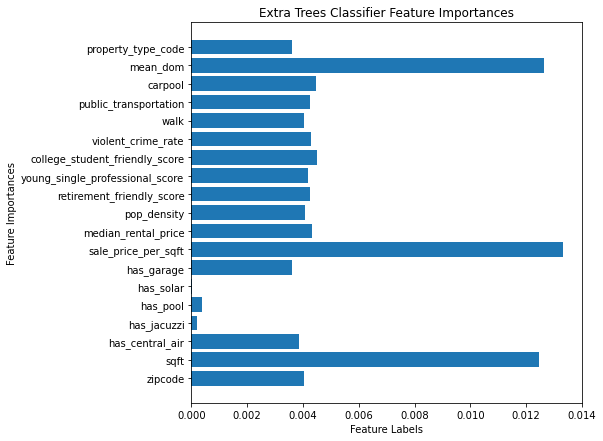

In [50]:
plt.figure(figsize=(7,7))
plt.barh(X.columns, feature_importance_normalized) 
plt.xlabel('Feature Labels') 
plt.ylabel('Feature Importances') 
plt.title('Extra Trees Classifier Feature Importances') 
plt.show() 

### Random Forest Classifier

In [53]:
rfc = RandomForestClassifier(max_depth=5, random_state=0)
rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, random_state=0)

In [54]:
print_results(rfc)

Train set accuracy: 0.6141500773561529
Test set accuracy: 0.6140762463343109


In [55]:
feature_importance_normalized = np.std([tree.feature_importances_ for tree in 
                                        rfc.estimators_], 
                                        axis = 0) 

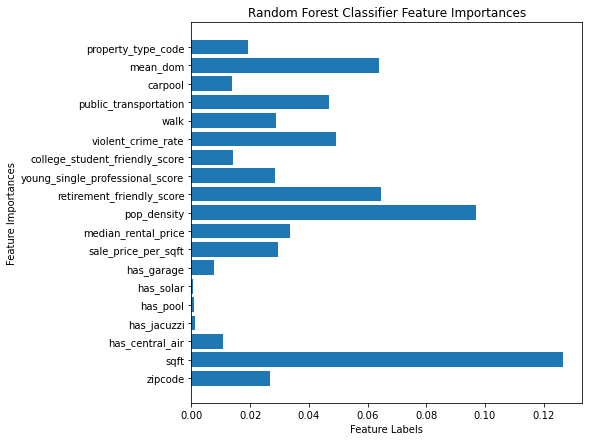

In [56]:
plt.figure(figsize=(7,7))
plt.barh(X.columns, feature_importance_normalized) 
plt.xlabel('Feature Labels') 
plt.ylabel('Feature Importances') 
plt.title('Random Forest Classifier Feature Importances') 
plt.show() 